In [32]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spy
from tqdm import tqdm
import time
import pickle
import glob
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.multitest import fdrcorrection

InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',None)

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [33]:
L2S={'Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease':
     'Hypertensive chronic kidney disease',
     'Personal history of other venous thrombosis and embolism':
     'Personal history of other venous thrombosis',
     'Presence of coronary angioplasty implant and graft':
     'Presence of coronary angioplasty implant',
     'Atherosclerotic heart disease of native coronary artery without angina pectoris':
     'Atherosclerotic native coronary artery disease',
     'Long term (current) use of antithrombotics/antiplatelets':
     'Long term (current) use of antithrombotics',
     'Hypertrophy (benign) of prostate without urinary obstruction and other lower urinary tract symptom (LUTS)':
     'Hypertrophy of prostate w/o urinary obstruction',
     'Benign prostatic hyperplasia without lower urinary tract symptoms':
     'Benign prostatic hyperplasia w/o urinary tract symptoms'}

# get predictive factors consistently identified in both ICD systems

In [38]:
icd9_to_10=pd.read_table("tables/icd9_to_icd10_conversion.txt", sep='\t', index_col=0)

    
def get_icd10_codes(ind_list):
    icd10_list=[]
    for ind in ind_list:
        if ind in icd9_to_10.index:
            icd10_list+=icd9_to_10.loc[ind].iloc[0].replace('.','').split(',')

    return icd10_list
    
def get_common_risk_factors(anal_method):
    ######### icd9

    
    risk_factor_icd9={}
    if anal_method=='chi':
        res_icd9=pd.read_table("tables/chi2_res_icd9_rev.txt", sep='\t', index_col=0).set_index('ICD-9')
    if anal_method=='xgb':
        res_icd9=pd.read_table("tables/xgb_res_icd9_rev.txt", sep='\t', index_col=0).set_index('ICD-9')
        
    for col in res_icd9.columns[:4]:
        sr1=res_icd9[col]
        sr2=sr1.loc[sr1.notnull()]
        risk_factor_icd9[col]=get_icd10_codes(sr2.index)

    ######### icd10
    risk_factor_icd10={}
    if anal_method=='chi':
        res_icd10=pd.read_table("tables/chi2_res_icd10_rev.txt", sep='\t', index_col=0).set_index('ICD-10')
    if anal_method=='xgb':
        res_icd10=pd.read_table("tables/xgb_res_icd10_rev.txt", sep='\t', index_col=0).set_index('ICD-10')
        
    
    for col in res_icd10.columns[:4]:
        sr1=res_icd10[col]
        risk_factor_icd10[col]=list(sr1.loc[sr1.notnull()].index)

    ############# shared_risk_factor1
    shared_risk_factor1={}
    for gp in ['AL','G1','G2','G3']:
        shared_risk_factor1[gp]=list(set(risk_factor_icd9[gp])&set(risk_factor_icd10[gp]))

    #############
    gp_df1=pd.DataFrame()
    for gp in ['AL','G1','G2','G3']:
        gp_sr1=pd.Series(name=gp, dtype=float)
        for icd_code in shared_risk_factor1[gp]:
            name1=res_icd10.loc[icd_code, 'long_title (ICD-10)'].split(',')[0]
            if name1 in L2S.keys():
                name1=L2S[name1]
            name_code='{} [{}]'.format(name1, icd_code)
            gp_sr1.loc[name_code]=1.0
        gp_df1=pd.concat([gp_df1, gp_sr1], axis=1)

    gp_df1['sum1']=gp_df1.sum(axis=1)
    gp_df1.loc['sum2']=gp_df1.sum(axis=0)
    gp_df1=gp_df1.sort_values(by='sum1', ascending=False).drop(columns='sum1')
    
    return gp_df1

# draw heatmap plot for overall predictive factors

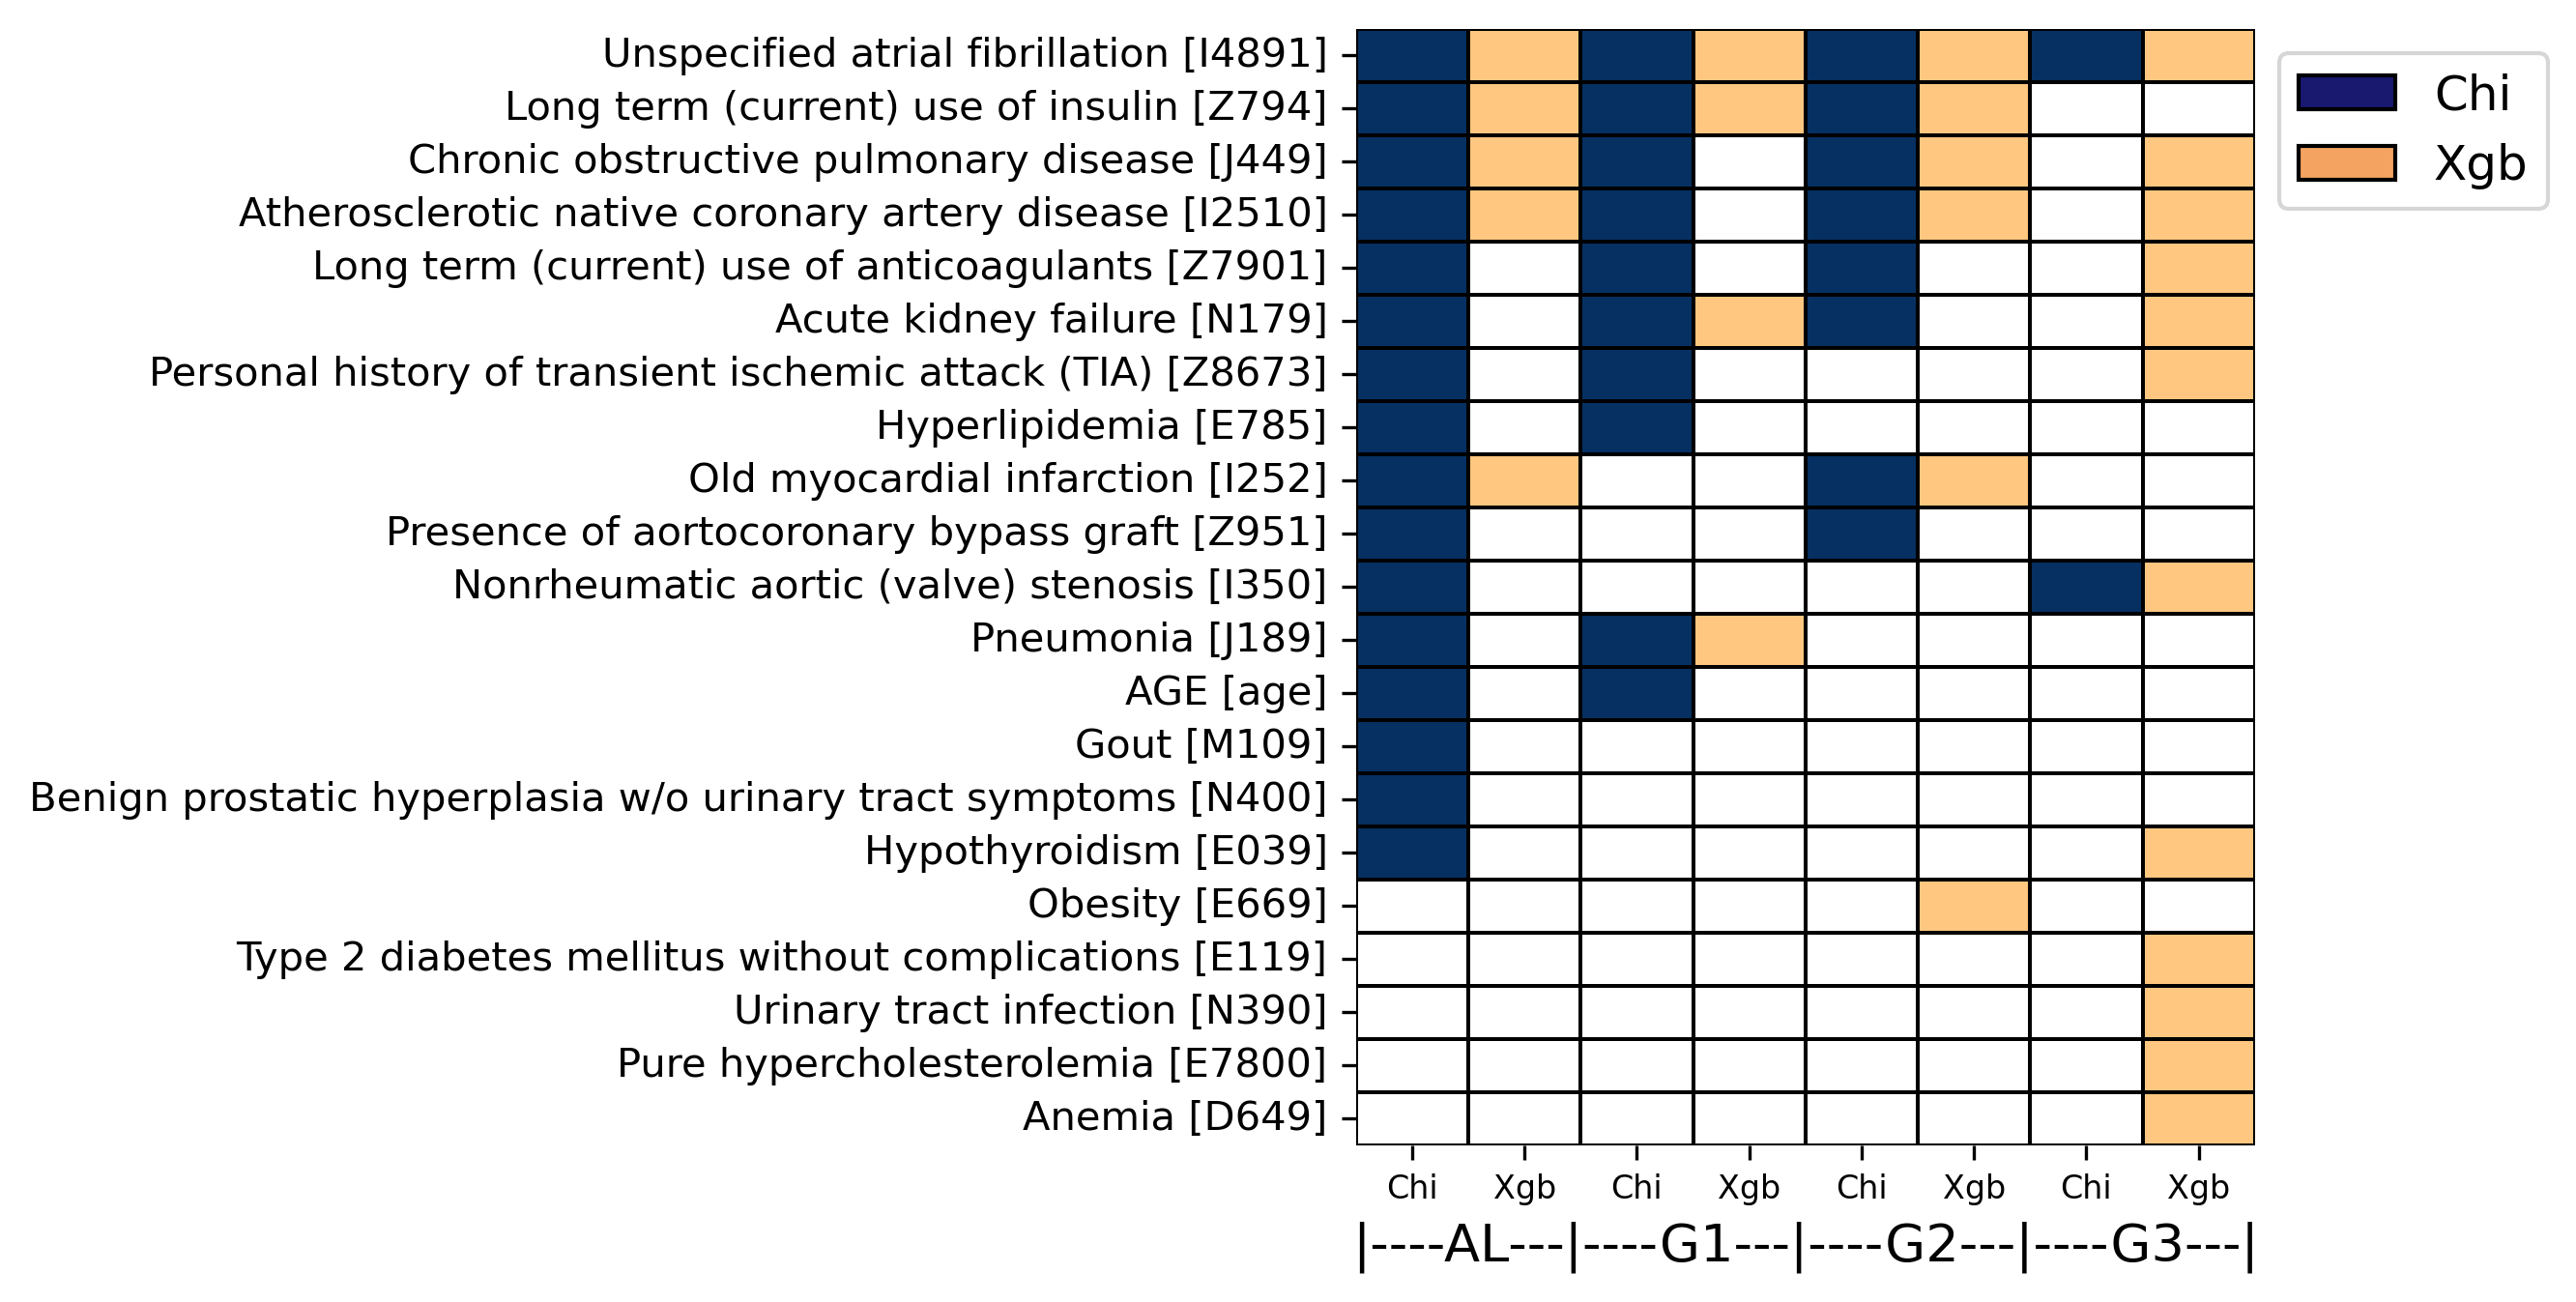

In [42]:
chi_df=get_common_risk_factors('chi')
chi_df.columns = pd.MultiIndex.from_tuples(list(zip(chi_df.columns, ['Chi']*4)))

xgb_df=get_common_risk_factors('xgb')
xgb_df.columns = pd.MultiIndex.from_tuples(list(zip(xgb_df.columns, ['Xgb']*4)))

concat_df=pd.concat([chi_df, xgb_df], axis=1).sort_index(axis=1).drop(index='sum2')
concat_df=concat_df.fillna(0)

fig=plt.figure(figsize=(4,5), dpi=300)
ax=fig.subplots()

heat_df1=concat_df.copy()
heat_df1.iloc[:,::2]=-1

_=sns.heatmap(heat_df1, ax=ax, cmap='copper', linecolor='k', linewidths=0.5, cbar=False, mask=(heat_df1==-1))

heat_df2=concat_df.copy()
heat_df2.iloc[:,1::2]=-1

_=sns.heatmap(heat_df2, ax=ax, cmap='RdBu', linecolor='k', linewidths=0.5, cbar=False, mask=(heat_df2==-1))

heat_df3=concat_df.copy()
_=sns.heatmap(heat_df3, ax=ax, cmap='Greys', linecolor='k', linewidths=0.5, vmin=0, vmax=10, cbar=False, mask=(heat_df3==1))

###########
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='midnightblue', edgecolor='k', label='Chi'),
                   Patch(facecolor='sandybrown', edgecolor='k', label='Xgb')]

# Create the figure
_=ax.legend(handles=legend_elements, bbox_to_anchor=(1,1), loc='upper left', fontsize=12)
_=ax.set_xticklabels(['Chi','Xgb']*4, fontsize=8, rotation=0)

x_label_space0='---|----'
x_label_space1='|----'
x_label_space2='---|'

_=ax.set_xlabel('{1}AL{0}G1{0}G2{0}G3{2}'.format(x_label_space0,x_label_space1,x_label_space2), fontsize=13)
fig.savefig('figures/commonly_identified_risk_factor.jpg', dpi=300, bbox_inches='tight')

In [43]:
concat_df.to_csv('tables/final_risk_factors.txt', sep='\t')